In [1]:
import os
import sys
import yaml
sys.path.append(os.path.abspath('.')) # to run files that are away
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB logs

libraries = ["torch", "numpy", "polars"]
modules   = {lib: sys.modules.get(lib) for lib in libraries}

if not modules["torch"]:
    import torch
if not modules["numpy"]:
    import numpy as np
if not modules["polars"]:
    import polars as pl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

from utils import compute_reconstruction_loss



/home/fouadabiad/miniconda3/envs/silofuse_env/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
"""Loading the data"""

with open('params.yaml', 'r') as file:
    yaml_config = yaml.safe_load(file)

data_file  = f"./datasets/{yaml_config['dataset']['filename']}"
df         = pd.read_csv(data_file)

X_scaled   = MinMaxScaler().fit_transform(df.values)
print(X_scaled.shape)
X_tensor   = torch.tensor(X_scaled, dtype=torch.float32)
# X_tensor_reshaped = X_tensor.transpose(0, 1)
# dataset    = TensorDataset(X_tensor_reshaped, X_tensor_reshaped)
dataset    = TensorDataset(X_tensor, X_tensor)  # Autoencoder reconstructs the input

num_time_series = len(dataset)
# train_size = int(yaml_config['dataset']['train_valid_split'] * len(df))
train_size = int(yaml_config['dataset']['train_valid_split'] * num_time_series)
# valid_size = len(df) - train_size
valid_size = num_time_series - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])


(19735, 28)


In [3]:
"""Autoencoder training"""

# import autoencoder as ae

# hidden_dim        = yaml_config['autoencoder_design']['hidden_dim']
# encoding_dim      = yaml_config['autoencoder_design']['encoding_dim']
# latent_dim        = yaml_config['autoencoder_design']['latent_dim']
# dropout_prob      = yaml_config['autoencoder_design']['dropout_prob']
# training_epochs   = yaml_config['autoencoder_training']['training_epochs']
# batch_size        = yaml_config['autoencoder_training']['batch_size']
# optimizer_lr      = yaml_config['autoencoder_training']['optimizer_lr']
# weight_decay      = yaml_config['autoencoder_training']['weight_decay']
# training_patience = yaml_config['autoencoder_training']['training_patience']
# scheduler_patience= yaml_config['autoencoder_training']['scheduler_patience']
# scheduler_mode    = yaml_config['autoencoder_training']['scheduler_mode']
# scheduler_factor  = yaml_config['autoencoder_training']['scheduler_factor']

# device = ae.device
# print(f"Using device from module: {device}")

# # Create DataLoader objects for train and validation datasets
# input_size   = X_scaled.shape[1]
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# autoencoder  = ae.Autoencoder(input_size, hidden_dim, encoding_dim, latent_dim, dropout_prob)
# optimizer    = torch.optim.AdamW(autoencoder.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
# scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, scheduler_mode, patience=scheduler_patience, factor=scheduler_factor)

# ae.train_autoencoder(device, autoencoder, training_epochs, train_loader, optimizer, scheduler,
#                      validation_loader=val_loader, patience = training_patience)


'Autoencoder training'

In [4]:
"""Run AE on dataset for reconstruction, anomaly detection, feature extraction, classification"""

# autoencoder.eval()
# autoencoder.to(device)

# with torch.no_grad():
#     X_input = X_tensor.to(device)
#     X_reconstructed = autoencoder(X_input).cpu().numpy()

# variate_to_plot = 9
# plt.plot(X_scaled[:300, variate_to_plot])
# plt.plot(X_reconstructed[:300, variate_to_plot])


'Run AE on dataset for reconstruction, anomaly detection, feature extraction, classification'

In [5]:
"""Evaluate AE reconstruction"""

# from utils import evaluate_and_plot_autoencoder_metrics

# should_we_plot = 1
# ks_stats, wasserstein_dists, real_acfs, generated_acfs, dtw_distances = evaluate_and_plot_autoencoder_metrics(X_scaled, X_reconstructed, should_we_plot)



'Evaluate AE reconstruction'

In [6]:
"""Diffusion training"""

import diffusion_model as diff
from diffusion_model import Diffusion, TrainDiffusion
from torch.utils.data import Dataset, DataLoader

diff_steps        = yaml_config['diffusion_design']['diff_steps']
cos_start_offset  = yaml_config['diff_noise_scheduler']['cos_start_offset']
noise_profile     = yaml_config['diff_noise_scheduler']['noise_profile']
start_noise_val   = yaml_config['diff_noise_scheduler']['start_noise_val']
end_noise_val     = yaml_config['diff_noise_scheduler']['end_noise_val']
batch_size        = yaml_config['diffusion_training']['batch_size']
train_epochs      = yaml_config['diffusion_training']['train_epochs']
training_patience = yaml_config['diffusion_training']['training_patience']
optimizer_lr      = yaml_config['diffusion_training']['optimizer_lr']
weight_decay      = yaml_config['diffusion_training']['weight_decay']
scheduler_patience= yaml_config['diffusion_training']['scheduler_patience']
scheduler_mode    = yaml_config['diffusion_training']['scheduler_mode']
scheduler_factor  = yaml_config['diffusion_training']['scheduler_factor']
dropout_prob      = yaml_config['Unet_design']['dropout_prob']
base_channels     = yaml_config['Unet_design']['base_channels']
embedding_dim     = yaml_config['Unet_design']['embedding_dim']

device = diff.device
print(f"Using device from module: {device}")

sequence_length = 128 # num of timesetps fed to model at once (longer = more history per training, but more memory)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data           = torch.tensor(data, dtype=torch.float32)
        self.sequence_length= sequence_length
        self.num_sequences  = len(data) - sequence_length

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx
        end_idx   = start_idx + self.sequence_length
        segment   = self.data[start_idx:end_idx].T  # Shape: (features, sequence_length)
        return segment

train_dataset_diffusion= TimeSeriesDataset(X_scaled[:train_size], sequence_length)
train_loader_diffusion = DataLoader(train_dataset_diffusion, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataset_diffusion  = TimeSeriesDataset(X_scaled[train_size:], sequence_length)
val_loader_diffusion   = DataLoader(val_dataset_diffusion, batch_size=batch_size, shuffle=False, drop_last=True)

betas = Diffusion.get_noise_schedule(start_noise_val, end_noise_val, diff_steps, cos_start_offset, noise_profile)
betas = betas.clamp(min=1e-8, max=0.999)  # <- Clamp here to avoid instability
print("Clamped betas range:", betas.min().item(), betas.max().item())

diffusion_model = diff.UNet(X_scaled.shape[1], dropout_prob, embedding_dim=embedding_dim, base_channels=base_channels)
optimizer       = torch.optim.AdamW(diffusion_model.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
scheduler       = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epochs)
# scheduler       = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,scheduler_mode, scheduler_factor, scheduler_patience)

train_diff = TrainDiffusion()
train_diff.train_diffusion(device, diffusion_model, train_loader_diffusion, optimizer, scheduler, betas,
                           diff_steps, train_epochs, val_loader_diffusion, training_patience)


Using device: cuda
Using device from module: cuda
Clamped betas range: 0.019999999552965164 0.019999999552965164
Epoch [1/200], loss: 0.0283, Validation loss: 0.0222
Epoch [2/200], loss: 0.0263, Validation loss: 0.0216
Epoch [3/200], loss: 0.0257, Validation loss: 0.0205
Epoch [4/200], loss: 0.0252, Validation loss: 0.0205
Epoch [5/200], loss: 0.0247, Validation loss: 0.0199
Epoch [6/200], loss: 0.0246, Validation loss: 0.0195
Epoch [7/200], loss: 0.0238, Validation loss: 0.0193
Epoch [8/200], loss: 0.0238, Validation loss: 0.0188
Epoch [9/200], loss: 0.0237, Validation loss: 0.0190
Epoch [10/200], loss: 0.0234, Validation loss: 0.0184
Epoch [11/200], loss: 0.0234, Validation loss: 0.0184
Epoch [12/200], loss: 0.0232, Validation loss: 0.0185
Epoch [13/200], loss: 0.0232, Validation loss: 0.0181
Epoch [14/200], loss: 0.0229, Validation loss: 0.0186
Epoch [15/200], loss: 0.0230, Validation loss: 0.0184
Epoch [16/200], loss: 0.0228, Validation loss: 0.0185
Epoch [17/200], loss: 0.0228, Va

(100, 28)
[  3.3082972  -5.245898   -3.0424254   7.0043144  -5.318345  -13.660587
  -7.6978593 -12.681746   -3.653789   -9.211614   -3.1659803  -3.774086
  -9.596379   -6.2503467  -3.8888023 -13.5124655 -37.864185  -32.575672
 -29.869183  -35.888577  -33.66658   -26.637962  -35.02387   -39.741455
 -39.86227   -30.341057  -34.246723  -41.453403  -37.701378  -40.856712
 -34.32515   -30.858686  -20.8222    -18.987572  -26.532907  -23.140236
 -23.572063  -30.519016  -31.787281  -27.610762  -21.795853  -24.79322
 -29.85316   -30.174706  -36.626476  -31.260778  -24.189402  -29.168083
 -18.680817  -16.244764  -10.707627  -16.76134    -5.9532423  -7.6150756
  -9.0561075  -7.45607   -15.267378  -16.34025   -19.83504   -12.341836
 -22.957813  -24.00403   -28.516663  -28.313044  -47.51085   -47.86786
 -47.669567  -46.36065   -50.481678  -53.799046  -59.80587   -55.89355
 -51.80129   -55.075848  -54.536613  -47.843     -55.12353   -55.275433
 -59.65807   -59.019     -50.743465  -52.350143  -60.006

/home/fouadabiad/projects/silofuse_timeseries/diffusion_model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas      = torch.tensor(betas, device=x_t.device)


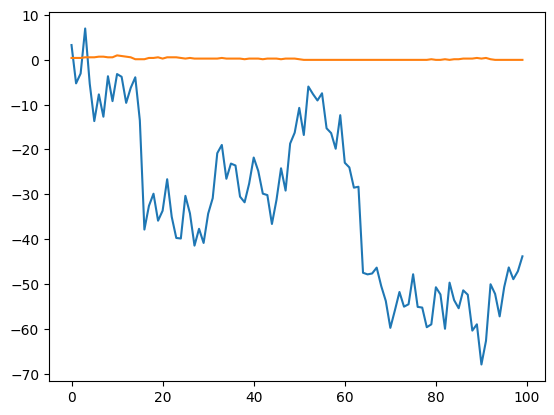

In [7]:
"""Generate new samples from diffusion"""

diffusion_model.eval()
diffusion_model.to(device)

desired_length = 100

with torch.no_grad():
    sample_shape     = (1, X_scaled.shape[1], desired_length)
    generated_samples= diff.sample_new_data(diffusion_model, betas, diff_steps, sample_shape)
    generated_array  = generated_samples.cpu().squeeze(0).numpy().T # Move to CPU then convert to NumPy

print(generated_array.shape)
print(generated_array[:,1])

plt.plot(generated_array[:, 1])
plt.plot(X_scaled[:desired_length, 1])



In [ ]:
"""successful diffusion runfile"""

# optimizer       = torch.optim.AdamW(diffusion_model.parameters(), lr=optimizer_lr, weight_decay=weight_decay)
# scheduler       = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epochs)

# diffusion_design:
#   diff_steps:         200       # num of diffusion steps

# diff_noise_scheduler:
#   noise_profile:      'q'       # l = linear, c = cos, q = quadratic
#   cos_start_offset:   0.008     # small offset that smooths the early part of cos schedule (avoid instability or extreme vals)
#   start_noise_val:    0.001     # start noise value, non-0 as it can create NaN values
#   end_noise_val:      0.01      # end noise value

# diffusion_training:
#   batch_size:         128       # number of samples per batch
#   train_epochs:       300       # num of diffusion training epochs
#   training_patience:  300       # how many epochs with no improvement to stop training
#   optimizer_lr:       0.00005   # learning rate for the optimizer
#   weight_decay:       0.00001   # for L2 regularization
#   scheduler_patience: 10
#   scheduler_mode:     'min'     # min (max) reduces learning rate when validation loss stops improving (starts increasing)
#   scheduler_factor:   0.5       # multiplies lr by this factor when validation loss plateaus

# Unet_design:
#   dropout_prob:       0.1  # probability of dropping units during training
#   base_channels:      18   # number of filters in 1st Unet layer
#   embedding_dim:      128  # time-step embedding size

# ===========================================
# better one
# diffusion_design:
#   diff_steps:         200       # num of diffusion steps

# diff_noise_scheduler:
#   noise_profile:      'q'       # l = linear, c = cos, q = quadratic
#   cos_start_offset:   0.008     # small offset that smooths the early part of cos schedule (avoid instability or extreme vals)
#   start_noise_val:    0.001     # start noise value, non-0 as it can create NaN values
#   end_noise_val:      0.01      # end noise value

# diffusion_training:
#   batch_size:         1024       # number of samples per batch (into dataloader)
#   train_epochs:       200       # num of diffusion training epochs
#   training_patience:  300       # how many epochs with no improvement to stop training
#   optimizer_lr:       0.005     # learning rate for the optimizer
#   weight_decay:       0.00001   # for L2 regularization
#   scheduler_patience: 10
#   scheduler_mode:     'min'     # min (max) reduces learning rate when validation loss stops improving (starts increasing)
#   scheduler_factor:   0.5       # multiplies lr by this factor when validation loss plateaus

# Unet_design:
#   dropout_prob:       0.1  # probability of dropping units during training
#   base_channels:      18   # number of filters in 1st Unet layer
#   embedding_dim:      128  # time-step embedding size

# ===========================================

# diffusion_design:
#   diff_steps:         100       # num of diffusion steps

# diff_noise_scheduler:
#   noise_profile:      'q'       # l = linear, c = cos, q = quadratic
#   cos_start_offset:   0.008     # small offset that smooths the early part of cos schedule (avoid instability or extreme vals)
#   start_noise_val:    0.001     # start noise value, non-0 as it can create NaN values
#   end_noise_val:      0.01      # end noise value

# diffusion_training:
#   batch_size:         1024       # number of samples per batch (into dataloader)
#   train_epochs:       200       # num of diffusion training epochs
#   training_patience:  300       # how many epochs with no improvement to stop training
#   optimizer_lr:       0.005     # learning rate for the optimizer
#   weight_decay:       0.00001   # for L2 regularization
#   scheduler_patience: 10
#   scheduler_mode:     'min'     # min (max) reduces learning rate when validation loss stops improving (starts increasing)
#   scheduler_factor:   0.5       # multiplies lr by this factor when validation loss plateaus

# Unet_design:
#   dropout_prob:       0.1  # probability of dropping units during training
#   base_channels:      18   # number of filters in 1st Unet layer
#   embedding_dim:      128  # time-step embedding size

# ===========================================
# NOTE: BEST
# diffusion_design:
#   diff_steps:         10       # num of diffusion steps

# diff_noise_scheduler:
#   noise_profile:      'q'       # l = linear, c = cos, q = quadratic
#   cos_start_offset:   0.008     # small offset that smooths the early part of cos schedule (avoid instability or extreme vals)
#   start_noise_val:    0.001     # start noise value, non-0 as it can create NaN values
#   end_noise_val:      0.01      # end noise value

# diffusion_training:
#   batch_size:         1024       # number of samples per batch (into dataloader)
#   train_epochs:       200       # num of diffusion training epochs
#   training_patience:  300       # how many epochs with no improvement to stop training
#   optimizer_lr:       0.005     # learning rate for the optimizer
#   weight_decay:       0.00001   # for L2 regularization
#   scheduler_patience: 10
#   scheduler_mode:     'min'     # min (max) reduces learning rate when validation loss stops improving (starts increasing)
#   scheduler_factor:   0.5       # multiplies lr by this factor when validation loss plateaus

# Unet_design:
#   dropout_prob:       0.1  # probability of dropping units during training
#   base_channels:      18   # number of filters in 1st Unet layer
#   embedding_dim:      128  # time-step embedding size


'successful diffusion runfile'

In [9]:
"""Making LDM"""

# Silofuse
num_clients = 3
clients_data= [X_scaled[:,1], X_scaled[:,2], X_scaled[:,3]]

latents = []
for data in clients_data:
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    latent = autoencoder.encode_to_latent(data_tensor)  # Use encode_to_latent method from Autoencoder class
    latents.append(latent)

# Step 2: Diffuse on Latents (Assume diffusion_model is defined and properly trained)
latents = torch.cat(latents, dim=0)  # Combine all latents (if needed)
synth_latents = diffusion_model(latents)  # Forward pass through the diffusion model

# Step 3: Decode the synthesized latents back to original data space
synth_data = []
for latent_data in synth_latents:
    synth_data.append(autoencoder.decode_from_latent(latent_data))  # Use decode_from_latent method

# Convert synthesized data to numpy for visualization or further analysis
synth_data = torch.stack(synth_data).cpu().numpy()

# Visualize generated data for comparison (choose a feature/variate to plot)
plt.plot(synth_data[0, :, 1])  # Plot second feature (variate 1)
plt.show()


NameError: name 'autoencoder' is not defined